In [13]:
#%load_ext autoreload
#%autoreload 2

import sys
sys.path
#rtg_path = '/nas/home/tg/work/libs2/rtg-30alnemb_tgt'
#sys.path.append(rtg_path)

['/nas/material/users/tg/work/material/y1/rtg-runs/mcss+nmt-paper/notes',
 '/nas/home/tg/work/libs2/rtg-30alnemb_tgt',
 '/nas/home/tg/libs/miniconda3/envs/torch-3.7/lib/python37.zip',
 '/nas/home/tg/libs/miniconda3/envs/torch-3.7/lib/python3.7',
 '/nas/home/tg/libs/miniconda3/envs/torch-3.7/lib/python3.7/lib-dynload',
 '',
 '/nas/home/tg/libs/miniconda3/envs/torch-3.7/lib/python3.7/site-packages',
 '/nas/home/tg/libs/miniconda3/envs/torch-3.7/lib/python3.7/site-packages/IPython/extensions',
 '/nas/home/tg/.ipython']

In [14]:
import torch
import torch.nn
torch.set_grad_enabled(False)
import rtg
from rtg import TranslationExperiment as Experiment, device
from rtg.module.decoder import Decoder
from pathlib import Path

In [15]:
basedir = Path('/nas/material/users/tg/work/material/y1/rtg-runs/mcss+nmt-paper')
mcss_exp = Experiment(basedir / '012-rnnattn-30a-emb8k', read_only=True)
mono_exp = Experiment(basedir / '012-rnnattn-30a-monoemb8k', read_only=True)
mcss_exp.model_type, mono_exp.model_type

INFO:root:Initializing an experiment. Directory = /nas/material/users/tg/work/material/y1/rtg-runs/mcss+nmt-paper/012-rnnattn-30a-emb8k
INFO:root:Initializing an experiment. Directory = /nas/material/users/tg/work/material/y1/rtg-runs/mcss+nmt-paper/012-rnnattn-30a-monoemb8k


('seq2seq', 'seq2seq')

In [16]:
mcss_dec = Decoder.new(exp=mcss_exp, ensemble=5)
mono_dec = Decoder.new(exp=mono_exp, ensemble=5)

INFO:root:Make RNN NMT model, args= {'src_lang': 'SOM', 'tgt_lang': 'ENG', 'src_vocab': 8000, 'tgt_vocab': 8000, 'emb_size': 300, 'hid_size': 300, 'n_layers': 1, 'attention': 'general', 'dropout': 0.2, 'tied_emb': None}
INFO:root:Loading aligned src embeddings.
INFO:root:Loaded aligned src embeddings: shape=torch.Size([8000, 300])
INFO:root:Loading aligned tgt embeddings.
INFO:root:Loaded aligned embeddings: shape=torch.Size([8000, 300])
INFO:root:Using attention=general model for decoding. tgt ext embedder is ON
INFO:root:Averaging 5 model states :: [PosixPath('/nas/material/users/tg/work/material/y1/rtg-runs/mcss+nmt-paper/012-rnnattn-30a-emb8k/models/model_128000_3.298214_2.947318.pkl'), PosixPath('/nas/material/users/tg/work/material/y1/rtg-runs/mcss+nmt-paper/012-rnnattn-30a-emb8k/models/model_124000_3.302215_2.977441.pkl'), PosixPath('/nas/material/users/tg/work/material/y1/rtg-runs/mcss+nmt-paper/012-rnnattn-30a-emb8k/models/model_120000_3.310848_2.973997.pkl'), PosixPath('/nas/

In [21]:
mcss_dec.decode_sentence("hello"), mono_dec.decode_sentence("hello")

([(-0.4455070495605469, 'hello'),
  (-2.989518165588379, 'hello .'),
  (-3.3437671661376953, 'hello ('),
  (-3.3453407287597656, 'hello ['),
  (-4.076017379760742, 'hello .lo')],
 [(-0.4184398651123047, 'hello'),
  (-2.347723960876465, 'hello ('),
  (-2.4456777572631836, 'hello .'),
  (-4.080041885375977, 'hello ['),
  (-4.574662208557129, 'hello ( hello')])

In [58]:
class AttentionViz:
    def __init__(self, dec):
        self.dec = dec
        self.exp = dec.exp
    
    def force_decode(self, src, tgt):
        in_seq = self.dec.inp_vocab.encode_as_ids(src, add_eos=True, add_bos=True)
        in_toks = list(map(self.dec.inp_vocab.id_to_piece, in_seq)) 
        
        out_seq = self.dec.out_vocab.encode_as_ids(tgt, add_eos=True, add_bos=True)
        out_toks = list(map(self.dec.out_vocab.id_to_piece, out_seq))
        
        x_seqs = torch.tensor(in_seq, dtype=torch.long, device=device).view(1, -1)
        x_lens = torch.tensor([len(in_seq)], dtype=torch.long, device=device)
        gen = self.dec.generator(x_seqs, x_lens)
        
        ys = torch.tensor(out_seq, dtype=torch.long, device=device).view(1, -1)
        score = 0
        src_attns = []
        for i in range(len(out_seq)-1):
            prev_out = ys[:, :i+1]
            log_prob, attn = gen.generate_next(prev_out, get_attn=True)
            src_attns.append(attn)
            log_prob = log_prob[0]  # just one sequence in batch
            score += log_prob[prev_out[0, -1]].item()

        out_toks = out_toks[1:]  # ignore the first BOS tok
        src_attns = torch.cat(src_attns, dim=0)
        return score, in_toks, out_toks, src_attns.tolist()
        
    def greedy_decode(self, sentence, max_len=20):
        in_seq = self.dec.inp_vocab.encode_as_ids(sentence, add_eos=True, add_bos=True)
        in_toks = list(map(self.dec.inp_vocab.id_to_piece, in_seq)) 

        x_seqs = torch.tensor(in_seq, dtype=torch.long, device=device).view(1, -1)
        x_lens = torch.tensor([len(in_seq)], dtype=torch.long, device=device)
        
        gen = self.dec.generator(x_seqs, x_lens)
        ys = torch.full(size=(1, 1), fill_value=self.dec.bos_val, dtype=torch.long, device=device)
        score = 0
        ended = False
        src_attns = []
        for i in range(1, max_len + 1):
            if ended:
                break
            log_prob, attn = gen.generate_next(ys, get_attn=True)
            src_attns.append(attn)
            max_prob, next_word = torch.max(log_prob, dim=1)
            #print(i, max_prob, next_word)
            score += max_prob.item()
            ys = torch.cat([ys, next_word.view(1, 1)], dim=1)
            ended = ys[0, -1] == self.dec.eos_val

        out_seq = ys[0, 1:].tolist()
        out_sent = self.dec.out_vocab.decode_ids(out_seq)
        out_toks = list(map(self.dec.out_vocab.id_to_piece, out_seq))
        src_attns = torch.cat(src_attns, dim=0)
        return score, in_toks, out_toks, src_attns.tolist()

mcss_av = AttentionViz(mcss_dec)
mono_av = AttentionViz(mono_dec)
mono_av.force_decode("hello", "hola")

(-45.66088104248047,
 ['<s>', '▁hel', 'lo', '</s>'],
 ['▁hol', 'a', '</s>'],
 [[0.00602260697633028,
   0.7666823267936707,
   0.14265689253807068,
   0.08463813364505768],
  [0.052661702036857605,
   0.49142205715179443,
   0.19685080647468567,
   0.2590654492378235],
  [0.009707148186862469,
   0.29541048407554626,
   0.13122180104255676,
   0.5636605620384216]])

In [42]:
import numpy as np
import matplotlib.pyplot as plt
params = {'legend.fontsize': 18,
          'figure.figsize': (15.0, 8.0),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':14,
         'ytick.labelsize':14,
         'font.size': 12}
plt.rcParams.update(params)

def viz_attn(src_toks, tgt_toks, attn,
             title=None):
    printlen(len(src_toks), len())
    fig, ax = plt.subplots()
    fig.set_size_inches(max(6, len(src_toks)*0.6),
                        max(6, len(tgt_toks)*0.6))
    im = ax.imshow(attn, cmap=plt.cm.Blues)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(src_toks)))
    ax.set_yticks(np.arange(len(tgt_toks)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(src_toks)
    ax.set_yticklabels(tgt_toks)
    
    ax.xaxis.tick_top()

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(tgt_toks)):
        for j in range(len(src_toks)):
            text = ax.text(j, i, '%.2f' % attn[i, j],
                           ha="center", va="center", color="grey")

    if title:
        ax.set_title(title)
    fig.tight_layout()
    plt.show()

In [64]:
def compare(sent, ref, greedy=False):
    print(f"Input: {sent}\nOutput: {ref}")
    print ("---- MCSS Force Decode -----")
    score, src_toks, tgt_toks, attn = mcss_av.force_decode(sent, ref)
    mcss_out = mcss_dec.out_vocab.detokenize(tgt_toks)
    print(f'MCSS FD: {score:g} :: {mcss_out}')
    viz_attn(src_toks, tgt_toks, np.array(attn), title="MCSS Force Decode")
    print ("---- ***** -----")

    print ("---- MONOLING Force Decode-----")
    score, src_toks, tgt_toks, attn = mono_av.force_decode(sent, ref)
    mono_out = mono_dec.out_vocab.detokenize(tgt_toks)
    print(f'MONO FD: {score:g} :: {mono_out}')
    viz_attn(src_toks, tgt_toks, np.array(attn), title="Monolingual Force Decode")
    print ("---- ***** -----")

    if greedy:
        print ("---- MCSS Greedy Decode -----")
        score, src_toks, tgt_toks, attn = mcss_av.greedy_decode(sent)
        mcss_out = mcss_dec.out_vocab.detokenize(tgt_toks)
        print(f'MCSS GD: {score:g} :: {mcss_out}')
        viz_attn(src_toks, tgt_toks, np.array(attn), title="MCSS Greedy Decode")
        print ("---- ***** -----")
        print ("---- MONOLING Greedy Decode-----")
        score, src_toks, tgt_toks, attn = mono_av.greedy_decode(sent)
        mono_out = mono_dec.out_vocab.detokenize(tgt_toks)
        print(f'MONO Gen: {score:g} :: {mono_out}')
        viz_attn(src_toks, tgt_toks, np.array(attn), title="Monolingual Greedy Decode")
        print ("---- ***** -----")


Input: cali xuseen ismaaciil ( shoombe ) .
Output: ali hussein ismael (shombe).
---- MCSS Force Decode -----
MCSS FD: -126.338 :: ali hussein ismael (shombe).</s>


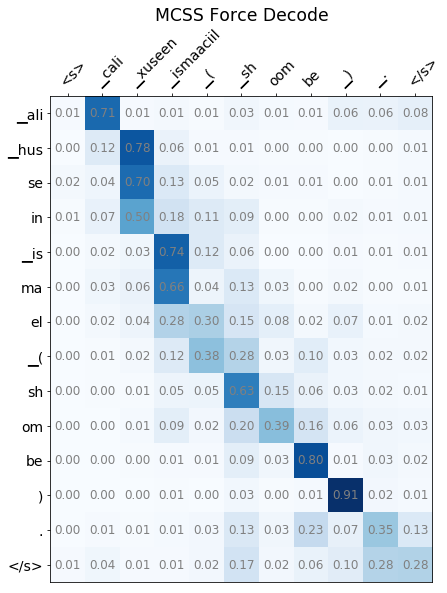

---- ***** -----
---- MONOLING Force Decode-----
MONO FD: -129.676 :: ali hussein ismael (shombe).</s>


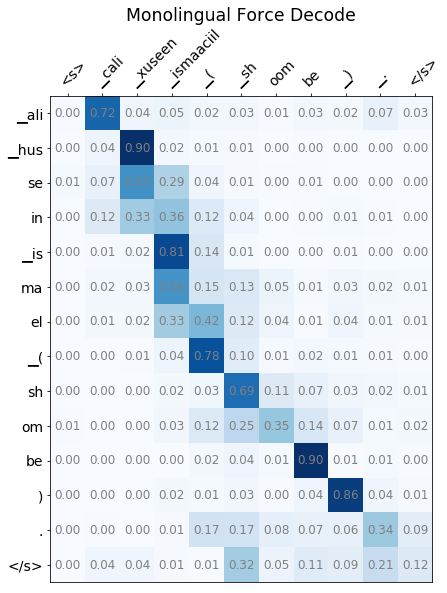

---- ***** -----
---- MCSS Greedy Decode -----
MCSS GD: -1.24938 :: ali hussein ismail ( shombe ) .</s>


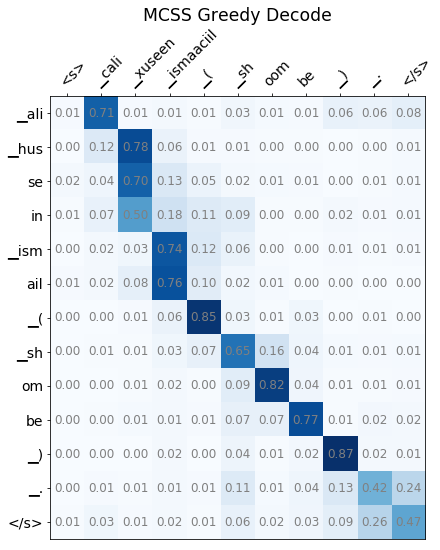

---- ***** -----
---- MONOLING Greedy Decode-----
MONO Gen: -1.36831 :: ali hussein ismail ( shoombe ) .</s>


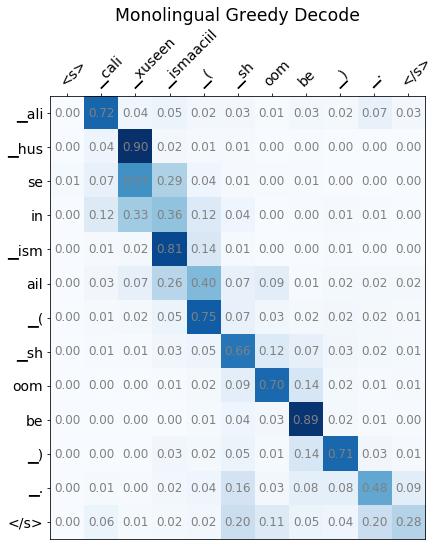

---- ***** -----


----------------


Input: sacdiyo daa , uud maxamed & axmed dayib axmed .
Output: saido david mohamed and ahmed dayib ahmed .
---- MCSS Force Decode -----
MCSS FD: -71.317 :: saido david mohamed and ahmed dayib ahmed .</s>


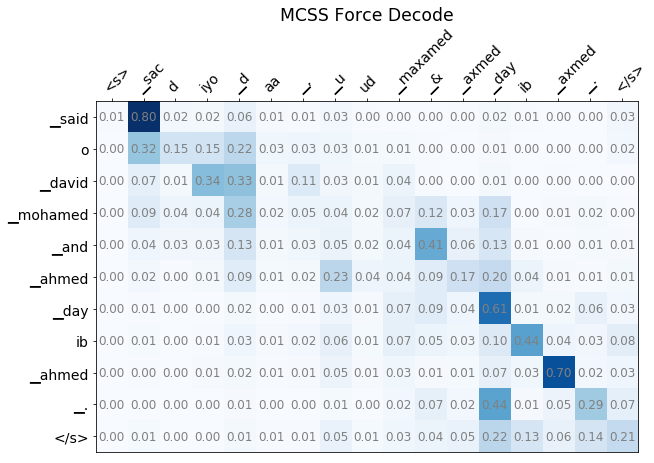

---- ***** -----
---- MONOLING Force Decode-----
MONO FD: -67.2891 :: saido david mohamed and ahmed dayib ahmed .</s>


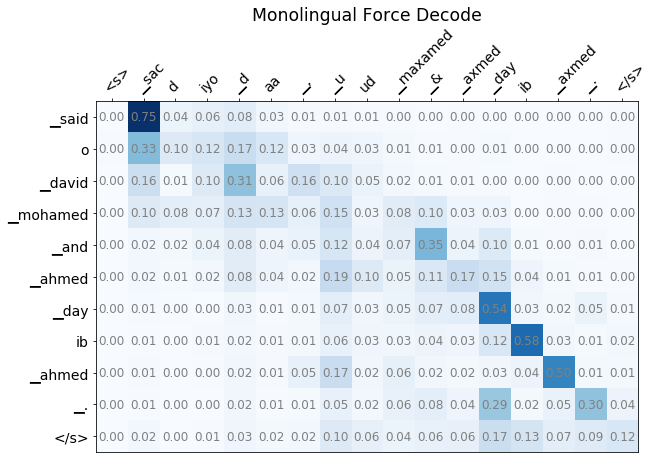

---- ***** -----
---- MCSS Greedy Decode -----
MCSS GD: -5.55696 :: saadiyo daa , uud mohamed & ahmed dayib ahmed .</s>


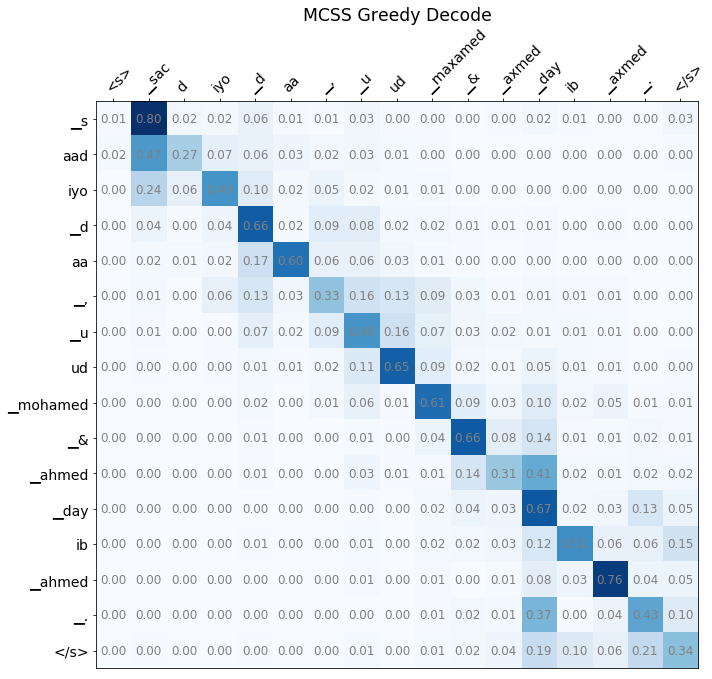

---- ***** -----
---- MONOLING Greedy Decode-----
MONO Gen: -6.52446 :: saudiyo daa , uud mohamed & ahmed dayib ahmed .</s>


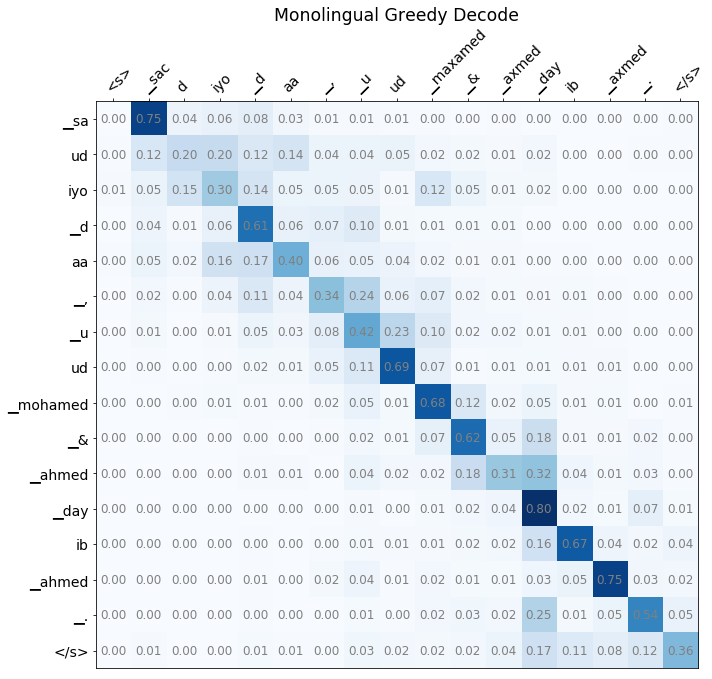

---- ***** -----


----------------




In [66]:

sents = [
#    ("iyagu waxay hadda deggan yihiin mountville , pennsylvania .",
#     "they are now living in mountville , pennsylvania ."),
    ("cali xuseen ismaaciil ( shoombe ) .", "ali hussein ismael (shombe)."),
    ("sacdiyo daa , uud maxamed & axmed dayib axmed .", "saido david mohamed and ahmed dayib ahmed .")
]
for src, ref in sents:
    compare(src, ref, greedy=True)
    print("\n\n----------------\n\n")
    